# Image Classification
In this project, it classifies images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. It preprocesses the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded. It gets to apply and build a convolutional, max pooling, dropout, and fully connected layers. At the end, it gets to see your neural network's predictions on the sample images.
## Get the Data
Download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [16]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory. The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data. Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


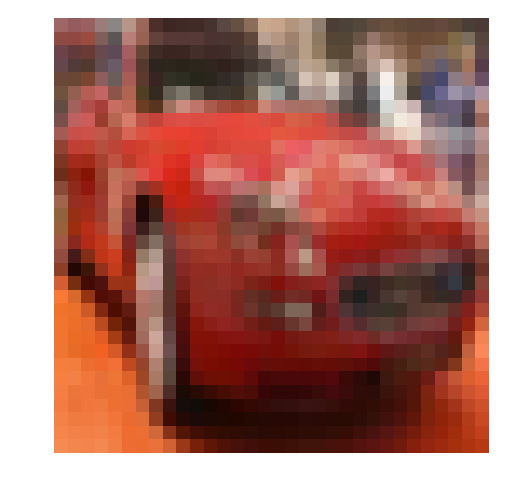

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [1]:
def normalize(x):
    return x / 255

### One-hot encode
The input, `x`, are a list of labels. Implement the function to return the list of labels as One-Hot encoded Numpy array. The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`. 

In [3]:
from sklearn import preprocessing

lb = np.zeros

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """        
    lb = preprocessing.LabelBinarizer()
    lb.fit(np.arange(0, 10))
    
    return lb.transform(x)

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [20]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
The preprocessed data has been saved to disk.

In [21]:
import pickle
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
To test a code more thoroughly, it puts each layer in a function.

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. It needs to implement the following functions
* `neural_net_image_input` 
 * The shape using `image_shape` with batch size set to `None`.
 * The TensorFlow placeholder "x" using the TensorFlow `name` parameter.
* `neural_net_label_input`
 * The shape using `n_classes` with batch size set to `None`.
 * The TensorFlow placeholder "y" using the TensorFlow `name` parameter.
* `neural_net_keep_prob_input`
 * The TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter.

The reason why it names is used at the end of the project to load your saved model.

In [4]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """    
    x = tf.placeholder(tf.float32, shape=[None, image_shape[0], image_shape[1], image_shape[2]], name="x")
    return x


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name="y")
    return y


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    return keep_prob

tf.reset_default_graph()

### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. In the function `conv2d_maxpool`, it applies convolution then max pooling.

In [5]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    
    weight = tf.Variable(tf.truncated_normal(
        [conv_ksize[0], 
         conv_ksize[1], 
         x_tensor.shape.as_list()[3], 
         conv_num_outputs], 
        dtype=tf.float32, 
        mean=0.0, 
        stddev=0.1))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    x_tensor = tf.nn.conv2d(
        x_tensor, 
        weight,
        strides=[1, conv_strides[0], conv_strides[1], 1], 
        padding='SAME'
    )
        
    x_tensor = tf.nn.bias_add(x_tensor, bias)
    x_tensor = tf.nn.relu(x_tensor) 
    x_tensor = tf.nn.max_pool(
        x_tensor, 
        ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
        strides=[1, pool_strides[0], pool_strides[1], 1], 
        padding='SAME'
    )
   
    return x_tensor

### Flatten Layer
The `flatten` function changes the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor. The output should be the shape (*Batch Size*, *Flattened Image Size*). 

In [6]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """    
    x_tensor_list = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor, [-1, np.prod(x_tensor_list[1:])])

### Fully-Connected Layer
The `fully_conn` function applies a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [7]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """    
    datasize = x_tensor.get_shape().as_list()[1]
    weight = tf.Variable(tf.truncated_normal([datasize, num_outputs], mean=0.0, stddev=0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
        
    fc = tf.add(tf.matmul(x_tensor, weight), bias)
    fc = tf.nn.relu(fc)
    return fc    

### Output Layer
The `output` function applies a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [8]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    datasize = x_tensor.get_shape().as_list()[1]
    weight = tf.Variable(tf.truncated_normal((datasize, num_outputs), mean=0.0, stddev=0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    op = tf.add(tf.matmul(x_tensor, weight), bias)    
    return op

### Create Convolutional Model
The function `conv_net` creates a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.

In [27]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    x_tensor = x
    conv_num_outputs = 128
    conv_ksize = (3,3)
    conv_strides = (1,1)
    pool_ksize = (4,4)
    pool_strides = (2,2)
    num_outputs = 10

    conv = conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv = conv2d_maxpool(conv, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv = conv2d_maxpool(conv, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv = tf.nn.dropout(conv, 0.5)
    
    flat = flatten(conv)
    
    fully = fully_conn(flat, num_outputs)
    fully = fully_conn(fully, num_outputs)
    
    out_data = output(fully, num_outputs)        
    
    return out_data

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Neural Network Built!


## Train the Neural Network
### Single Optimization
The function `train_neural_network` does a single optimization. The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

In [9]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """    
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})

### Show Stats
The function `print_stats` prints loss and validation accuracy, using the global variables `valid_features` and `valid_labels` to calculate validation accuracy. 

In [29]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
    accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
    print("Loss: {}".format(loss))
    print("Accuracy: {}".format(accuracy))

### Hyperparameters
It needs to tune the parameters such as epochs, batch size and probability.

In [10]:
epochs = 30
batch_size = 256
keep_probability = 0.9

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, it should use a single batch. This should save time while you iterate on the model to get a better accuracy. Once the final validation accuracy is 50% or greater, it is good time to run the model on all the data in the next section.

In [32]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.2893524169921875
Accuracy: 0.0997999906539917
Epoch  2, CIFAR-10 Batch 1:  Loss: 2.254088878631592
Accuracy: 0.1599999964237213
Epoch  3, CIFAR-10 Batch 1:  Loss: 2.127584934234619
Accuracy: 0.22059999406337738
Epoch  4, CIFAR-10 Batch 1:  Loss: 1.8518706560134888
Accuracy: 0.2343999743461609
Epoch  5, CIFAR-10 Batch 1:  Loss: 1.8600269556045532
Accuracy: 0.3012000024318695
Epoch  6, CIFAR-10 Batch 1:  Loss: 1.9553940296173096
Accuracy: 0.3421999514102936
Epoch  7, CIFAR-10 Batch 1:  Loss: 1.7856810092926025
Accuracy: 0.378199964761734
Epoch  8, CIFAR-10 Batch 1:  Loss: 1.5966763496398926
Accuracy: 0.38519999384880066
Epoch  9, CIFAR-10 Batch 1:  Loss: 1.4588996171951294
Accuracy: 0.4147999584674835
Epoch 10, CIFAR-10 Batch 1:  Loss: 1.3290361166000366
Accuracy: 0.45179998874664307
Epoch 11, CIFAR-10 Batch 1:  Loss: 1.1075053215026855
Accuracy: 0.46859997510910034
Epoch 12, CIFAR-10 Batch 1:  Loss: 1.060532

### Fully Train the Model
Now that I got a good accuracy with a single CIFAR-10 batch, it is able to try it with all five batches.

In [33]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.264411687850952
Accuracy: 0.17520000040531158
Epoch  1, CIFAR-10 Batch 2:  Loss: 1.9326225519180298
Accuracy: 0.2173999845981598
Epoch  1, CIFAR-10 Batch 3:  Loss: 1.7253888845443726
Accuracy: 0.2825999855995178
Epoch  1, CIFAR-10 Batch 4:  Loss: 1.7438682317733765
Accuracy: 0.32919999957084656
Epoch  1, CIFAR-10 Batch 5:  Loss: 1.6822879314422607
Accuracy: 0.33079999685287476
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.86350679397583
Accuracy: 0.3789999783039093
Epoch  2, CIFAR-10 Batch 2:  Loss: 1.7456343173980713
Accuracy: 0.3999999761581421
Epoch  2, CIFAR-10 Batch 3:  Loss: 1.4464119672775269
Accuracy: 0.40779995918273926
Epoch  2, CIFAR-10 Batch 4:  Loss: 1.628647804260254
Accuracy: 0.44579997658729553
Epoch  2, CIFAR-10 Batch 5:  Loss: 1.331862211227417
Accuracy: 0.4527999758720398
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.446594476699829
Accuracy: 0.4737999737262726
Epoch  3, CIFAR-10 Batch 2:  Loss: 1.3071966171264648
Accuracy: 0.4790000021

# Checkpoint
The model has been saved to disk.
## Test Model
It needs to test the model against the test dataset. 

Testing Accuracy: 0.75400390625



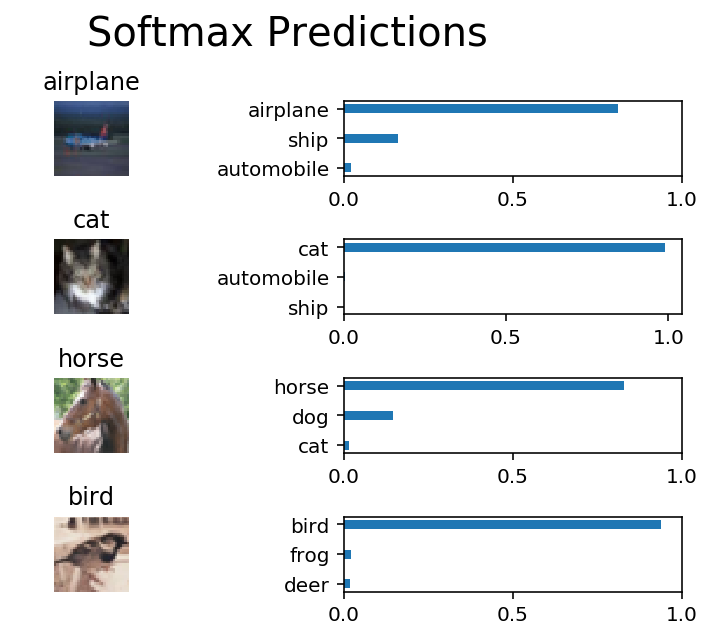

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Conclusion
Although I use convolution neural network (CNN), I can't get an accuracy over 80%. Of course, this is not bad for a simple CNN. However, I have to apply advanced CNN, VGG16, Xception, Googlenet, ResNet or something if I want to get a higher accuracy.haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.